In [7]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import base64
import PIL

from bezier import curve
from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

### set up paths

In [8]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [9]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [10]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num8_shape4']

# which iteration name should we use?
iterationName = 'run3' #increment when needed
# this has previously been run1, then sandbox3, but switched to sandbox 3 for testing the url recording function


In [11]:
## here is what one of these records looks like
coll.find_one()


{'_id': ObjectId('5ea11f9677a5814e85793c69'),
 'iterationName': 'sandboxtest2',
 'gameid': '3601-22bb9a7f-f441-4ec3-a2ed-678cea977bbc',
 'time': 1587617686433.0,
 'trialNum': 1,
 'workerId': 'ATHO7Y5CT91O3',
 'assignmentId': '3U5NZHP4LV2Q6K2EN75E91NSKGVPHG',
 'intendedName': 'owl_5',
 'svgData': 'M97,104c50.95184,0 110.84203,-9.43865 155,20c6.35227,4.23484 35.54189,36.45811 25,47c-1.82059,1.82059 -2.92187,-0.575 -4,0c-44.57034,23.77085 -101.51569,42.65189 -152,45c-10.55139,0.49076 -39.53347,7.93307 -48,-9c-28.67466,-57.34933 51.55221,-127.99261 77,-69c28.33338,65.68192 -45.21961,130.94619 -84,72c-13.26402,-20.16131 -23.22808,-104.95727 28,-80c23.65797,11.52568 30.13693,49.37655 38,71c0.04431,0.12186 8.90106,26 15,26',
 'currStrokeNum': '1',
 'shiftKeyUsed': '0',
 'previous_score': '0',
 'previous_bonus_score': '0',
 'startStrokeTime': '1587617682284',
 'endStrokeTime': '1587617683600',
 'eventType': 'stroke'}

### Initialize dataframes

In [12]:
## trials
k = coll.find({'iterationName':iterationName, 'eventType':'clickedObj'})
k2 = coll.find({'iterationName':'run2', 'eventType':'clickedObj'})
K = pd.DataFrame(k)
K2 = pd.DataFrame(k2)
K = K.append(K2, ignore_index=True)

## strokes
t = coll.find({'iterationName':iterationName, 'eventType':'stroke'})
t2 = coll.find({'iterationName':'run2', 'eventType':'stroke'})
T = pd.DataFrame(t)
T2 = pd.DataFrame(t2)
T = T.append(T2, ignore_index=True)


## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==32] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

## save out to csv
T.to_csv(os.path.join(csv_dir,'photodraw_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'photodraw_sketch_data.csv'),index=False)

## generate group dataframe and save out to file
importlib.reload(utils)
D = utils.generate_dataframe(coll, complete_gameids, iterationName, csv_dir)
# D2 = utils.generate_dataframe(coll, complete_gameids, 'run2', csv_dir)
# D = D.append(D2, ignore_index=True)


# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

def GetArcLenData(df):
    """
    This requires the dataframe to have a ['svgString'] column to analyse.
    It returns the same dataframe, but with an extra column of 'stroke_len_means'.
    Currently just taking the total arc length of each stroke, and averaging them per sketch.
    
    If not already, import Path, Arc, CubicBezier, and parse_path from svg.path
    Used this: https://pypi.org/project/svg.path/
    """
    stroke_len_means = []
    for row_num in range(len(df['svgString'])):
        stroke_lengths = []
        for stroke_num in range(len(df['svgString'][row_num])):
            stroke_length = 0
            for curve in parse_path(D['svgString'][row_num][stroke_num]):
                stroke_length += curve.length(error=1e-5)
            stroke_lengths.append(stroke_length)
        stroke_len_means.append(np.mean(stroke_lengths))
    new_df = df
    new_df['stroke_len_means'] = stroke_len_means
    return new_df

D = GetArcLenData(D)

# Keep track of which quarter of the experiment the trial happened in
D['quarter'] = np.ceil(D['trialNum']/8)
D = D.astype({'quarter': 'float'})



Done!


In [13]:
## monitor how far along games-in-progress are
all_games = K['gameid'].unique()
num_games = len(all_games)
print('There are a total of {} unique gameids in mongo.'.format(num_games))

print('\n')
print('These are the games and how many trials have been completed so far:')
for name, group in K.groupby('gameid'):
    print('gameid: {} | number of trials : {}'.format(name, group.shape[0]))

There are a total of 16 unique gameids in mongo.


These are the games and how many trials have been completed so far:
gameid: 0095-d4a81902-118c-4dda-bf91-6522bd3c1b7d | number of trials : 32
gameid: 1135-f8a97bb7-107c-41c5-b871-7bc08ef01068 | number of trials : 32
gameid: 1372-60cdfd55-28bb-411c-b777-c51eaadee7a9 | number of trials : 32
gameid: 3157-91bcaadf-d5e1-42b1-9ae5-28f7f804924f | number of trials : 32
gameid: 4883-809f3003-8522-4324-aaed-db25f45f98ff | number of trials : 32
gameid: 5506-e5927b09-479f-41b7-a302-97941f3f4dc1 | number of trials : 32
gameid: 5758-dbed9675-da5b-45fc-b315-975dec4b654a | number of trials : 32
gameid: 6265-a70bd0e5-9111-4b9d-a54d-892f121eb60f | number of trials : 32
gameid: 6769-3ee1e797-2c5b-4441-8d67-5ccd1c6b9a73 | number of trials : 32
gameid: 7035-7157c91f-91bb-47ce-871b-d6b3c42570fb | number of trials : 32
gameid: 7252-68b73956-7131-4e0f-ac7b-fa77929a0638 | number of trials : 32
gameid: 8172-8d856686-c62d-4f5a-b203-4e7deae74ab9 | number of trial

In [ ]:
## TODO: hash 'workerId' so that we do not save actual workerIDs to file.

### render out all the sketches

In [14]:
importlib.reload(utils)
utils.render_images(K,data = 'pngString',
                    metadata = ['gameid','intendedName','trialNum','game_condition'],
                    out_dir = sketch_dir)

Done rendering 512 images to /Users/alles/iterated_number/sketches.


### make sketch gallery (for complete games only)

In [15]:
importlib.reload(utils)
## actually render sketch gallery for each complete game
utils.render_sketch_gallery(complete_gameids,
                            D,
                            sketch_dir = sketch_dir,
                            gallery_dir = gallery_dir,
                            num_trials = 32,
                            by_trialnum = False,
                            show_correct = True,
                            transpose=False)

Generating sketch gallery for participant: 6265-a70bd0e5-9111-4b9d-a54d-892f121eb60f | 1 of 16
Generating sketch gallery for participant: 0095-d4a81902-118c-4dda-bf91-6522bd3c1b7d | 2 of 16
Generating sketch gallery for participant: 8172-8d856686-c62d-4f5a-b203-4e7deae74ab9 | 3 of 16
Generating sketch gallery for participant: 5758-dbed9675-da5b-45fc-b315-975dec4b654a | 4 of 16
Generating sketch gallery for participant: 3157-91bcaadf-d5e1-42b1-9ae5-28f7f804924f | 5 of 16
Generating sketch gallery for participant: 9628-1c609e18-d1d3-4ed7-b3a2-79c927abf904 | 6 of 16
Generating sketch gallery for participant: 8735-55ad7c25-0992-4a50-a068-72bf9c59cce0 | 7 of 16
Generating sketch gallery for participant: 8334-fed22f63-dad9-4faa-82ec-96b4561ff0b2 | 8 of 16
Generating sketch gallery for participant: 1135-f8a97bb7-107c-41c5-b871-7bc08ef01068 | 9 of 16
Generating sketch gallery for participant: 7252-68b73956-7131-4e0f-ac7b-fa77929a0638 | 10 of 16
Generating sketch gallery for participant: 7035-7

## Analysis things

In [21]:
D.columns
D.to_csv('all_data.csv')

### Additional derived measures we might want

In [24]:
# # Just trials where all distractors were of different animal category than the target
# D_animal = D.loc[(D['category'] != D['D1_Cat']) & (D['category'] != D['D2_Cat']) & (D['category'] != D['D3_Cat'])]
# D_animal[['trialNum','category','cardinality','D1_Cat','D1_Car','D2_Cat','D2_Car','D3_Cat','D3_Car']]


# to get differences between 1st and 3rd
# D1_sorted = D_1st.sort_values('cardinality')[['cardinality','meanPixelIntensity']].to_numpy()
# D4_sorted = D_4th.sort_values('cardinality')[['cardinality','meanPixelIntensity']].to_numpy()

# D_diff = pd.DataFrame({'cardinality': D1_sorted[:,0],
#                        'pixelIntensityDiff': D1_sorted[:,1] - D4_sorted[:,1]})


# General purpose function for plotting measurements separately by quarter of the experiment
def PlotByQuarter(title, d, xvar='cardinality',yvar='numStrokes',ylabel='Strokes per Sketch',cond='all',subp=None):
    if xvar=='cardinality':
        xlabel = 'Cardinality'
    elif xvar=='category':
        xlabel = 'Animal'
    
    if cond == 'all':
        df = d
    else:
        df = d.loc[d['Game_Condition'] == cond]
        
    D_1st = df.loc[df['quarter'] == 1.0]
    D_2nd = df.loc[df['quarter'] == 2.0]
    D_3rd = df.loc[df['quarter'] == 3.0]
    D_4th = df.loc[df['quarter'] == 4.0]
    
#     plt.figure(title)
#     plt.title(title)
    sns.pointplot(data=D_1st, x=xvar, y=yvar,color='#000000',markers='.',ax=subp).set_title(title)
    sns.pointplot(data=D_2nd, x=xvar, y=yvar,color='#960202',markers='.',ax=subp) #bb3f3f
    sns.pointplot(data=D_3rd, x=xvar, y=yvar,color='#D57810',markers='.',ax=subp) #edda07
    sns.pointplot(data=D_4th, x=xvar, y=yvar,color='#EDC917',markers='.',ax=subp) #6a0dad
    sns.pointplot(data=df, x=xvar, y=yvar,color='#25B1F7',markers='.', ax=subp, linestyles='--') # average all
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    black_patch = mpatches.Patch(color='#000000', label='1st block')
    red_patch = mpatches.Patch(color='#960202', label='2nd block')
    yellow_patch = mpatches.Patch(color='#D57810', label='3rd block')
    purple_patch = mpatches.Patch(color='#EDC917', label='4th block')
    blue_patch = mpatches.Patch(color='#25B1F7', label='Average')
    plt.legend(handles=[black_patch, red_patch, yellow_patch, purple_patch, blue_patch])

# PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity")
# PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch")
# PlotByQuarter("Curves per Stroke",D,yvar='numCurvesPerStroke',ylabel="Curves per Stroke")

# PlotByQuarter("Curves per Stroke (Animal)",D,xvar='category',yvar='numCurvesPerStroke',ylabel="Curves per Stroke")
# PlotByQuarter("Strokes per Sketch (Animal)",D,xvar='category',yvar='numStrokes',ylabel="Strokes per Sketch")

# PlotByQuarter("Mean Stroke Length by Cardinality",D,yvar='stroke_len_means',ylabel="Mean Stroke Length")
# PlotByQuarter("Sketch Time by Cardinality",D,yvar='drawDuration',ylabel="Sketch Time")

print('Done')


Done


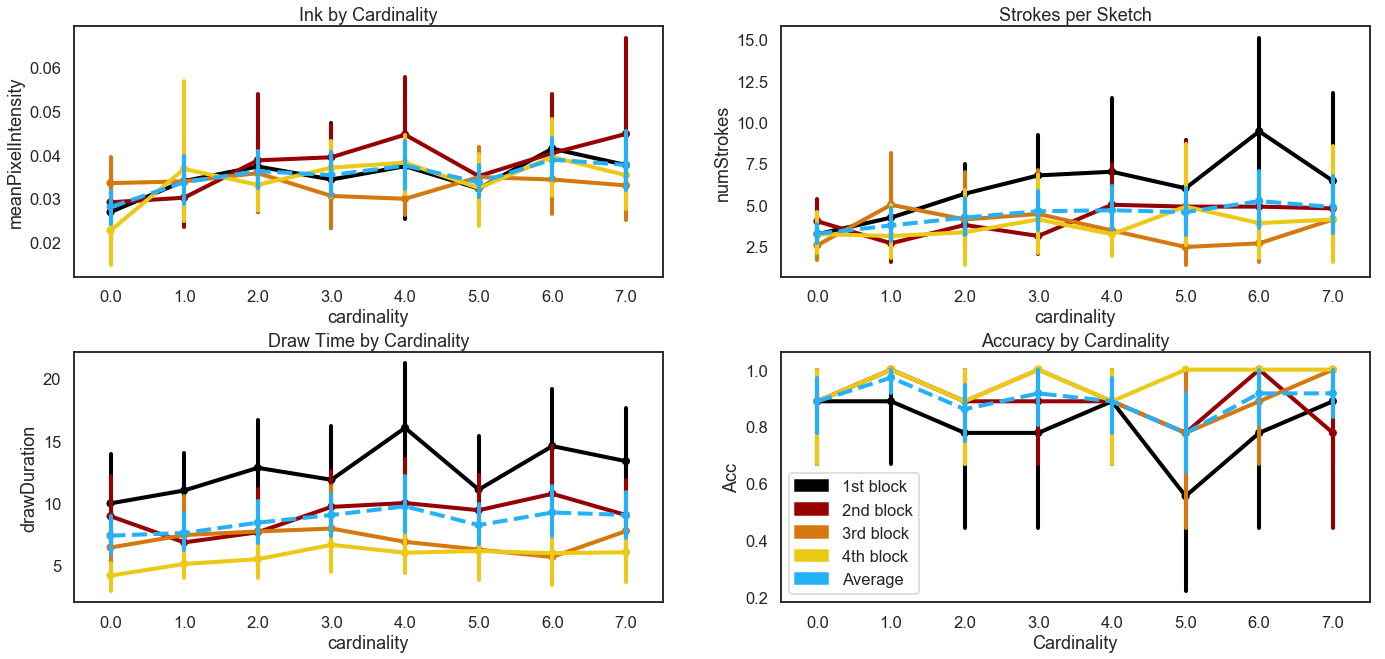

In [25]:
# Plot data for just shape condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='shape',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='shape',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='shape',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='shape',subp=ax4)

plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


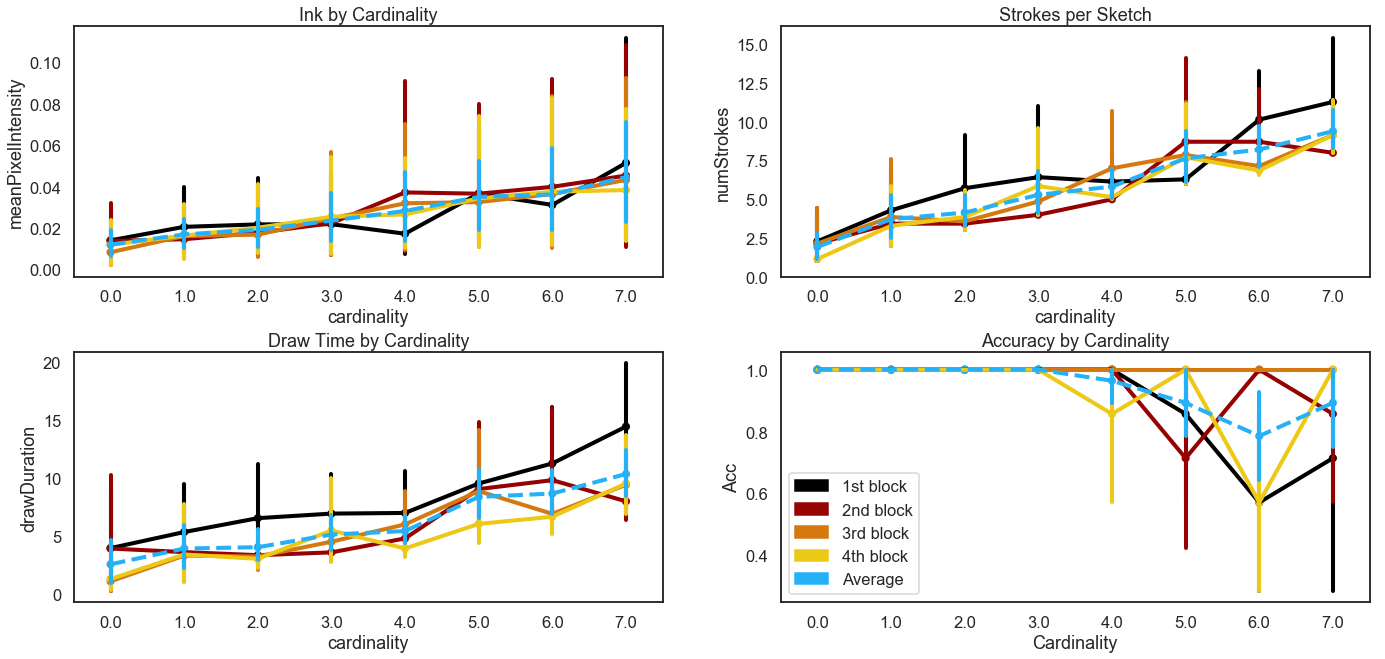

In [26]:
# Plot data for just number condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='number',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='number',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='number',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='number',subp=ax4)

plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


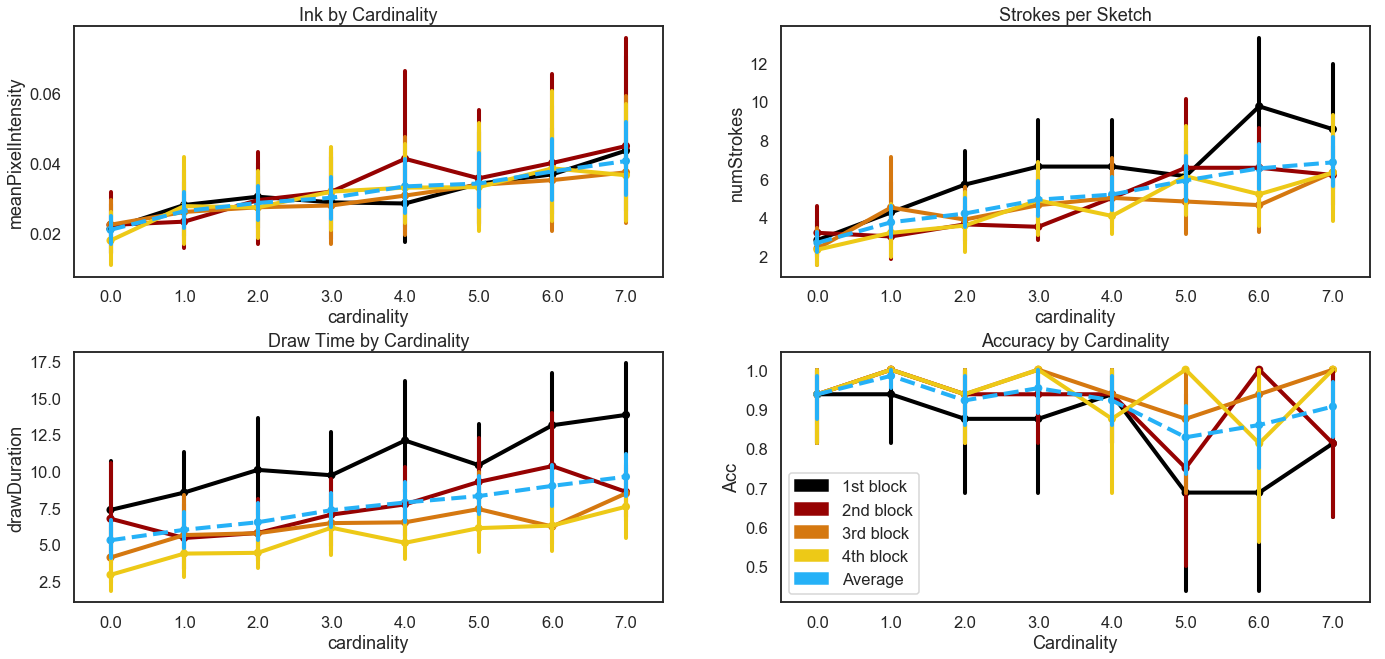

In [27]:
# Plot data for just shape condition
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

PlotByQuarter("Ink by Cardinality",D,yvar='meanPixelIntensity',ylabel="Mean Pixel Intensity",cond='all',subp=ax1)
PlotByQuarter("Strokes per Sketch",D,yvar='numStrokes',ylabel="Strokes per Sketch",cond='all',subp=ax2)

PlotByQuarter("Draw Time by Cardinality",D,yvar='drawDuration',ylabel="Draw Time",cond='all',subp=ax3)
PlotByQuarter("Accuracy by Cardinality",D,yvar='outcome',ylabel="Acc",cond='all',subp=ax4)


plt.subplots_adjust(left=1,right=4,bottom=1,top=3,wspace=.2,hspace=.3)


### analyze performance (accuracy and RT)

In [ ]:
acc_table = D.groupby('gameID')['outcome'].mean().reset_index()
acc_table.head()

In [ ]:
D['drawDuration'] = pd.to_numeric(D['drawDuration'])
acc_table = D.groupby('gameID')['drawDuration'].mean().reset_index()
acc_table

In [ ]:
# for some reason, .mean() doesn't work on these. But .sum() and .count() do, so gonna use that
x = D.groupby(['cardinality'])[['cardinality','numCurvesPerStroke']].sum()
y = D.groupby(['cardinality'])[['cardinality','numCurvesPerStroke']].count()

print(x/y)
#sns.pointplot(data=D, x='trialNum', y='numCurvesPerStroke')
sns.pointplot(data=D, x='trialNum', y='numCurvesPerStroke')

## What statistics do we want to look at?

### Measures of iconicity:

In [ ]:
# Complexity (number of curves) and ink (pixel intensity) per cardinality and between animals

plt.figure()
sns.barplot(data=D, x='cardinality', y='numStrokes')
plt.figure()
sns.barplot(data=D, x='cardinality', y='numCurvesPerSketch')
plt.figure()
sns.barplot(data=D, x='cardinality', y='meanPixelIntensity')

In [ ]:
plt.figure()
sns.barplot(data=D, x='category', y='numStrokes')
plt.figure()
sns.barplot(data=D, x='category', y='numCurvesPerSketch')
plt.figure()
sns.barplot(data=D, x='category', y='meanPixelIntensity')

In [ ]:
# linear regression....


#stats.linregress(D.groupby('cardinality')['drawDuration'])
D.groupby(['cardinality'])[['quarter','drawDuration']]
